<a href="https://colab.research.google.com/github/nlaimr/Intro-Deep-Learning-Notebooks/blob/master/Words1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

In [ ]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [ ]:
from six.moves.urllib.request import urlretrieve
#Takes ~15 minutes
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)

#medium-sized file - 94.6 MB
if (not os.path.isfile(snli_zip_file) and
    not os.path.isfile(snli_dev_file)):
    urlretrieve ("https://nlp.stanford.edu/projects/snli/snli_1.0.zip", 
                 snli_zip_file)

In [ ]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)
unzip_single_file(snli_zip_file, snli_dev_file)
# unzip_single_file(snli_zip_file, snli_full_dataset_file)

In [ ]:
glove_wordmap = {}
with open(glove_vectors_file, "r") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [ ]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

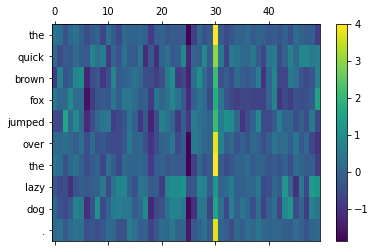

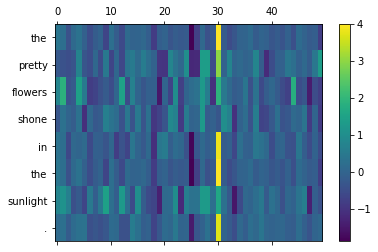

In [ ]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

In [ ]:
#Constants setup
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 50, 64

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 1

input_p, output_p = 0.5, 0.5

training_iterations_count = 100000

display_step = 10

def score_setup(row):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    score = np.zeros((3,))
    for x in range(1,6):
        tag = row["label"+str(x)]
        if tag in convert_dict: score[convert_dict[tag]] += 1
    return score / (1.0*np.sum(score))

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res

In [ ]:
def split_data_into_scores():
    import csv
    with open("snli_1.0_dev.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence1"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence2"].lower())[0]))
            labels.append(row["gold_label"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
    
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [ ]:
#tf.reset_default_graph()
tf.compat.v1.reset_default_graph()

In [ ]:
lstm = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(lstm_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "


In [ ]:
lstm_drop =  tf.compat.v1.nn.rnn_cell.DropoutWrapper(lstm, input_p, output_p)

In [ ]:
tf.compat.v1.reset_default_graph()
lstm = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(lstm_size)
lstm_drop =  tf.compat.v1.nn.rnn_cell.DropoutWrapper(lstm, input_p, output_p)
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
tf.compat.v1.disable_eager_execution()
hyp = tf.compat.v1.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.compat.v1.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.compat.v1.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
lstm_back = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(lstm_size)
# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.compat.v1.nn.rnn_cell.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.compat.v1.get_variable('fc_weight', [2*hidden_size, 3], initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.compat.v1.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.compat.v1.add_to_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.compat.v1.nn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [ ]:
with tf.compat.v1.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.compat.v1.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES))


optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

In [ ]:
# Initialize variables
init = tf.compat.v1.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.compat.v1.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:

    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))

  0%|          | 3/782 [00:02<18:43,  1.44s/it]

Iter 0.0, Minibatch Loss= 1.136975, Training Accuracy= 0.28906


  2%|▏         | 13/782 [00:02<03:57,  3.24it/s]

Iter 10.0, Minibatch Loss= 1.083430, Training Accuracy= 0.43750


  3%|▎         | 23/782 [00:03<01:32,  8.23it/s]

Iter 20.0, Minibatch Loss= 1.097638, Training Accuracy= 0.36719


  4%|▍         | 33/782 [00:04<01:06, 11.29it/s]

Iter 30.0, Minibatch Loss= 1.093487, Training Accuracy= 0.39844


  5%|▌         | 43/782 [00:05<01:00, 12.21it/s]

Iter 40.0, Minibatch Loss= 1.085315, Training Accuracy= 0.38281


  7%|▋         | 53/782 [00:06<00:57, 12.58it/s]

Iter 50.0, Minibatch Loss= 1.093293, Training Accuracy= 0.37500


  8%|▊         | 63/782 [00:06<00:57, 12.54it/s]

Iter 60.0, Minibatch Loss= 1.077751, Training Accuracy= 0.41406


  9%|▉         | 73/782 [00:07<00:54, 12.90it/s]

Iter 70.0, Minibatch Loss= 1.086088, Training Accuracy= 0.39062


 11%|█         | 83/782 [00:08<00:54, 12.94it/s]

Iter 80.0, Minibatch Loss= 1.091801, Training Accuracy= 0.39844


 12%|█▏        | 93/782 [00:09<00:52, 13.04it/s]

Iter 90.0, Minibatch Loss= 1.082077, Training Accuracy= 0.39062


 13%|█▎        | 103/782 [00:10<00:54, 12.53it/s]

Iter 100.0, Minibatch Loss= 1.089592, Training Accuracy= 0.37500


 14%|█▍        | 113/782 [00:10<00:53, 12.47it/s]

Iter 110.0, Minibatch Loss= 1.081927, Training Accuracy= 0.43750


 16%|█▌        | 123/782 [00:11<00:50, 12.95it/s]

Iter 120.0, Minibatch Loss= 1.075867, Training Accuracy= 0.44531


 17%|█▋        | 133/782 [00:12<00:49, 13.11it/s]

Iter 130.0, Minibatch Loss= 1.090205, Training Accuracy= 0.38281


 18%|█▊        | 143/782 [00:13<00:50, 12.67it/s]

Iter 140.0, Minibatch Loss= 1.074253, Training Accuracy= 0.43750


 20%|█▉        | 153/782 [00:13<00:50, 12.53it/s]

Iter 150.0, Minibatch Loss= 1.085869, Training Accuracy= 0.40625


 21%|██        | 163/782 [00:14<00:47, 13.11it/s]

Iter 160.0, Minibatch Loss= 1.082695, Training Accuracy= 0.46875


 22%|██▏       | 173/782 [00:15<00:50, 12.14it/s]

Iter 170.0, Minibatch Loss= 1.074323, Training Accuracy= 0.41406


 23%|██▎       | 183/782 [00:16<00:47, 12.71it/s]

Iter 180.0, Minibatch Loss= 1.064982, Training Accuracy= 0.44531


 25%|██▍       | 193/782 [00:17<00:46, 12.79it/s]

Iter 190.0, Minibatch Loss= 1.092553, Training Accuracy= 0.35156


 26%|██▌       | 203/782 [00:17<00:46, 12.44it/s]

Iter 200.0, Minibatch Loss= 1.072176, Training Accuracy= 0.39844


 27%|██▋       | 213/782 [00:18<00:45, 12.56it/s]

Iter 210.0, Minibatch Loss= 1.056574, Training Accuracy= 0.49219


 29%|██▊       | 223/782 [00:19<00:43, 12.89it/s]

Iter 220.0, Minibatch Loss= 1.058067, Training Accuracy= 0.46094


 30%|██▉       | 233/782 [00:20<00:44, 12.21it/s]

Iter 230.0, Minibatch Loss= 1.079593, Training Accuracy= 0.42188


 31%|███       | 243/782 [00:21<00:42, 12.74it/s]

Iter 240.0, Minibatch Loss= 1.066616, Training Accuracy= 0.48438


 32%|███▏      | 253/782 [00:21<00:41, 12.60it/s]

Iter 250.0, Minibatch Loss= 1.126423, Training Accuracy= 0.35156


 34%|███▎      | 263/782 [00:22<00:40, 12.88it/s]

Iter 260.0, Minibatch Loss= 1.088224, Training Accuracy= 0.42969


 35%|███▍      | 273/782 [00:23<00:39, 12.84it/s]

Iter 270.0, Minibatch Loss= 1.078143, Training Accuracy= 0.38281


 36%|███▌      | 283/782 [00:24<00:39, 12.79it/s]

Iter 280.0, Minibatch Loss= 1.049033, Training Accuracy= 0.48438


 37%|███▋      | 293/782 [00:24<00:37, 12.92it/s]

Iter 290.0, Minibatch Loss= 1.052362, Training Accuracy= 0.42188


 39%|███▊      | 303/782 [00:25<00:37, 12.68it/s]

Iter 300.0, Minibatch Loss= 1.054415, Training Accuracy= 0.50000


 40%|████      | 313/782 [00:26<00:38, 12.18it/s]

Iter 310.0, Minibatch Loss= 1.073400, Training Accuracy= 0.39062


 41%|████▏     | 323/782 [00:27<00:34, 13.21it/s]

Iter 320.0, Minibatch Loss= 1.069999, Training Accuracy= 0.39062


 43%|████▎     | 333/782 [00:27<00:35, 12.73it/s]

Iter 330.0, Minibatch Loss= 1.039186, Training Accuracy= 0.46094


 44%|████▍     | 343/782 [00:28<00:35, 12.30it/s]

Iter 340.0, Minibatch Loss= 1.085784, Training Accuracy= 0.35156


 45%|████▌     | 353/782 [00:29<00:32, 13.14it/s]

Iter 350.0, Minibatch Loss= 1.045801, Training Accuracy= 0.47656


 46%|████▋     | 363/782 [00:30<00:33, 12.46it/s]

Iter 360.0, Minibatch Loss= 0.999085, Training Accuracy= 0.50781


 48%|████▊     | 373/782 [00:31<00:33, 12.31it/s]

Iter 370.0, Minibatch Loss= 1.100352, Training Accuracy= 0.38281


 49%|████▉     | 383/782 [00:31<00:34, 11.64it/s]

Iter 380.0, Minibatch Loss= 1.066147, Training Accuracy= 0.42188


 50%|█████     | 393/782 [00:32<00:31, 12.54it/s]

Iter 390.0, Minibatch Loss= 1.050909, Training Accuracy= 0.41406


 52%|█████▏    | 403/782 [00:33<00:30, 12.28it/s]

Iter 400.0, Minibatch Loss= 1.067608, Training Accuracy= 0.47656


 53%|█████▎    | 413/782 [00:34<00:31, 11.84it/s]

Iter 410.0, Minibatch Loss= 1.046247, Training Accuracy= 0.48438


 54%|█████▍    | 423/782 [00:35<00:28, 12.45it/s]

Iter 420.0, Minibatch Loss= 1.055891, Training Accuracy= 0.49219


 55%|█████▌    | 433/782 [00:36<00:27, 12.53it/s]

Iter 430.0, Minibatch Loss= 1.057264, Training Accuracy= 0.43750


 57%|█████▋    | 443/782 [00:36<00:26, 12.66it/s]

Iter 440.0, Minibatch Loss= 1.067769, Training Accuracy= 0.44531


 58%|█████▊    | 453/782 [00:37<00:25, 12.91it/s]

Iter 450.0, Minibatch Loss= 1.075984, Training Accuracy= 0.42188


 59%|█████▉    | 463/782 [00:38<00:25, 12.71it/s]

Iter 460.0, Minibatch Loss= 1.022461, Training Accuracy= 0.50000


 60%|██████    | 473/782 [00:39<00:24, 12.56it/s]

Iter 470.0, Minibatch Loss= 1.056720, Training Accuracy= 0.41406


 62%|██████▏   | 483/782 [00:39<00:23, 12.49it/s]

Iter 480.0, Minibatch Loss= 1.103891, Training Accuracy= 0.35156


 63%|██████▎   | 493/782 [00:40<00:22, 12.63it/s]

Iter 490.0, Minibatch Loss= 1.062147, Training Accuracy= 0.44531


 64%|██████▍   | 503/782 [00:41<00:21, 12.78it/s]

Iter 500.0, Minibatch Loss= 1.059920, Training Accuracy= 0.43750


 66%|██████▌   | 513/782 [00:42<00:21, 12.40it/s]

Iter 510.0, Minibatch Loss= 1.055288, Training Accuracy= 0.49219


 67%|██████▋   | 523/782 [00:43<00:20, 12.78it/s]

Iter 520.0, Minibatch Loss= 1.047576, Training Accuracy= 0.49219


 68%|██████▊   | 533/782 [00:43<00:19, 12.45it/s]

Iter 530.0, Minibatch Loss= 1.048116, Training Accuracy= 0.46094


 69%|██████▉   | 543/782 [00:44<00:19, 12.08it/s]

Iter 540.0, Minibatch Loss= 1.060154, Training Accuracy= 0.46094


 71%|███████   | 553/782 [00:45<00:20, 11.05it/s]

Iter 550.0, Minibatch Loss= 1.055510, Training Accuracy= 0.46094


 72%|███████▏  | 563/782 [00:46<00:18, 11.81it/s]

Iter 560.0, Minibatch Loss= 1.072870, Training Accuracy= 0.43750


 73%|███████▎  | 573/782 [00:47<00:16, 12.56it/s]

Iter 570.0, Minibatch Loss= 1.041291, Training Accuracy= 0.43750


 75%|███████▍  | 583/782 [00:48<00:15, 12.48it/s]

Iter 580.0, Minibatch Loss= 1.062024, Training Accuracy= 0.42969


 76%|███████▌  | 593/782 [00:48<00:15, 12.41it/s]

Iter 590.0, Minibatch Loss= 1.017965, Training Accuracy= 0.48438


 77%|███████▋  | 603/782 [00:49<00:14, 12.16it/s]

Iter 600.0, Minibatch Loss= 1.021154, Training Accuracy= 0.51562


 78%|███████▊  | 613/782 [00:50<00:14, 11.56it/s]

Iter 610.0, Minibatch Loss= 1.038147, Training Accuracy= 0.44531


 80%|███████▉  | 623/782 [00:51<00:13, 12.11it/s]

Iter 620.0, Minibatch Loss= 1.056486, Training Accuracy= 0.41406


 81%|████████  | 633/782 [00:52<00:11, 12.70it/s]

Iter 630.0, Minibatch Loss= 1.012101, Training Accuracy= 0.53125


 82%|████████▏ | 643/782 [00:52<00:11, 11.74it/s]

Iter 640.0, Minibatch Loss= 1.022638, Training Accuracy= 0.53125


 84%|████████▎ | 653/782 [00:53<00:10, 11.73it/s]

Iter 650.0, Minibatch Loss= 1.011306, Training Accuracy= 0.54688


 85%|████████▍ | 663/782 [00:54<00:10, 11.74it/s]

Iter 660.0, Minibatch Loss= 1.037687, Training Accuracy= 0.50781


 86%|████████▌ | 673/782 [00:55<00:08, 12.16it/s]

Iter 670.0, Minibatch Loss= 1.040874, Training Accuracy= 0.51562


 87%|████████▋ | 683/782 [00:56<00:07, 12.63it/s]

Iter 680.0, Minibatch Loss= 1.029845, Training Accuracy= 0.46094


 89%|████████▊ | 693/782 [00:57<00:07, 12.67it/s]

Iter 690.0, Minibatch Loss= 1.013664, Training Accuracy= 0.53125


 90%|████████▉ | 703/782 [00:57<00:06, 12.64it/s]

Iter 700.0, Minibatch Loss= 1.033916, Training Accuracy= 0.47656


 91%|█████████ | 713/782 [00:58<00:05, 12.42it/s]

Iter 710.0, Minibatch Loss= 1.029265, Training Accuracy= 0.51562


 92%|█████████▏| 723/782 [00:59<00:04, 12.51it/s]

Iter 720.0, Minibatch Loss= 1.061692, Training Accuracy= 0.47656


 94%|█████████▎| 733/782 [01:00<00:04, 11.99it/s]

Iter 730.0, Minibatch Loss= 1.026235, Training Accuracy= 0.46875


 95%|█████████▌| 743/782 [01:01<00:03, 12.02it/s]

Iter 740.0, Minibatch Loss= 1.003820, Training Accuracy= 0.51562


 96%|█████████▋| 753/782 [01:01<00:02, 11.96it/s]

Iter 750.0, Minibatch Loss= 1.062427, Training Accuracy= 0.42188


 98%|█████████▊| 763/782 [01:02<00:01, 11.94it/s]

Iter 760.0, Minibatch Loss= 1.080020, Training Accuracy= 0.42969


 99%|█████████▉| 773/782 [01:03<00:00, 11.91it/s]

Iter 770.0, Minibatch Loss= 1.027566, Training Accuracy= 0.53906


100%|██████████| 782/782 [01:04<00:00, 12.18it/s]

Iter 780.0, Minibatch Loss= 0.986779, Training Accuracy= 0.56250


In [ ]:
evidences = ["Maurita and Jade both were at the scene of the car crash."]

hypotheses = ["Multiple people saw the accident."]

sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]

prediction = sess.run(classification_scores, feed_dict={hyp: (sentence1 * N),
                                                        evi: (sentence2 * N),
                                                        y: [[0,0,0]]*N})
print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " entailment")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Positive entailment


In [ ]:
evidences = ["I went to the store yesterday."]

hypotheses = ["My dog is nine."]

sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]

prediction = sess.run(classification_scores, feed_dict={hyp: (sentence1 * N),
                                                        evi: (sentence2 * N),
                                                        y: [[0,0,0]]*N})
print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " entailment")

Positive entailment


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [ ]:
sess.close()